In [61]:
# Librerias
import os
from bs4 import BeautifulSoup, NavigableString
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import re
from threading import Thread
import queue

In [62]:
# Parámetros
sourceDataFolder = "1-input"

bumeraniterationNumber = "5"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

intermFilesFolder = "2-process"
mergedMainFolder = "3-output"
otherOutputFolder = "../2-data-preparation/1-input/main/"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [63]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  #if tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }) is not None: 
  #  print(parseNames(parseLineBreaksAndAccents(tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }).text)))
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [64]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  print("Archivos originales: " + str(len(files)))

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  print("Archivos filtrados solo con postulaciones: " + str(len(filesFiltered)))

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-input\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-input\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-input\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-input\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-input\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-input\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-input\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-input\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-input\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
    #r"1-input\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(196).html"
    #r"1-input\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador.NET_(1).html"
    #r"1-input\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador. Net_(26).html"
    #r"1-input\main\bumeran\iteration-5\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(18).html"
    #r"1-input\main\bumeran\iteration-5\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(92).html"
    #r"1-input\main\bumeran\iteration-5\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(108).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta (se mantiene en iteracion 4 y 5)
    r"1-input\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-input\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-input\main\bumeran\iteration-5\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
  ]

  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  print("Archivos filtrados solo con data completa: " + str(len(filesFilteredNotIn)))

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [65]:
def getEncodingBumeran(file):
  candidateLog = ""

  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      candidateLog = candidateLog + file + "\n"
      candidateLog = candidateLog + traceback.format_exc() + "\n"
      candidateLog = candidateLog + "\n"
      pass
      
  return encoding, candidateLog

In [66]:
def getCandidateBumeran(file, encoding, candidateLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["candidatePostulationDate"] = postulationDate.strftime("%A, %B %d, %Y %I:%M %p")

      # ID de la convocatoria
      TitleTagsText = soup.find("p", {"style": "margin-top:10.5pt;margin-right:0in;margin-bottom:10.5pt;margin-left:\n15.0pt;background:whitesmoke"}).findAll(string=True)
      cleanJobIdText = parseNames(parseLineBreaksAndAccents(TitleTagsText[3]))
      candidateData["jobId"] = cleanJobIdText[cleanJobIdText.find(":")+2:cleanJobIdText.find(")")]

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["jobProfileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      liTags = soup.find_all("ul", {"type": "disc"})[0].find_all("li")

      # Nombre del candidato
      firstLinePased = parseNames(parseLineBreaksAndAccents(liTags[0].text))
      candidateData["candidateFullName"] = firstLinePased
      
      # Pais de residencia
      expectedCivilStatusValues = ["Soltero/A", "Casado/A", "Divorciado/A", "Pareja De Hecho", "Viudo/A", "Union Libre"]
      secondLineParsed = parseNames(parseLineBreaksAndAccents(liTags[1].text))
      firstcommaIndex = secondLineParsed.find(",")
      if firstcommaIndex != -1:
        candidateData["candidateResidenceCountry"] = secondLineParsed[:firstcommaIndex]
      else:
        candidateData["candidateResidenceCountry"] = ""

      # Estado civil
      civilStatus = ""
      for value in expectedCivilStatusValues:
        if value in secondLineParsed:
          civilStatus = value
      candidateData["candidateCivilStatus"] = civilStatus

      # Numero de documento
      # Propiedad especial del rfind, el -1 coincide con el inicio del string, por lo que es lo mismo tomarlo con o sin el indice, en caso el index no sea -1
      lastSpaceIndex = secondLineParsed.rfind(" ")
      candidateData["candidateDocumentNumber"] = re.sub("[^0-9]", "", secondLineParsed[lastSpaceIndex+1:])
      
      # Fecha de nacimiento
      thirdLineParsed = parseNames(parseLineBreaksAndAccents(liTags[2].text))
      birthDate = thirdLineParsed[thirdLineParsed.find(":")+2:]
      if birthDate != "":
        candidateData["candidateBirthDate"] = datetime.datetime.strptime(thirdLineParsed[thirdLineParsed.find(":")+2:], "%d-%m-%Y").strftime("%Y-%m-%d")
      else:
        candidateData["candidateBirthDate"] = ""

      # Pais de nacimiento
      fourthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[3].text))
      candidateData["candidateBirthCountry"] = fourthLineParsed[fourthLineParsed.find(":")+2:]

      # Dirección
      fifthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[4].text))
      candidateData["candidateAddress"] = fifthLineParsed
    
      # Telefonos
      sixthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[5].text))
      candidateData["candidateHomeNumber"] = sixthLineParsed[sixthLineParsed.find("Tel.")+5:sixthLineParsed.find("/")]
      candidateData["candidateCellphoneNumber"] = sixthLineParsed[sixthLineParsed.find("/")+2:]

      # Correo
      seventhLineParsed = parseNames(parseLineBreaksAndAccents(liTags[6].text))
      candidateData["candidateEmail"] = seventhLineParsed

      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)
      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)

      # Objetivo laboral, salario
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)
      if startIndex and endIndex:
        if (endIndex - startIndex) == 3:
          workObjectiveTag = mainChildTags[startIndex+2]
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0
          liTags = workObjectiveTag.find_all("li")
          for liTag in liTags:
            parsedText = parseNames(parseLineBreaksAndAccents(liTag.text))
            if "Objetivo Laboral:" in parsedText:
              candidateData["workObjetive"] = parsedText[parsedText.find("Objetivo Laboral: ")+18:]
            if "Sueldo Pretendido:" in parsedText:
              candidateData["salary"] = int(parsedText[parsedText.find("$")+1:parsedText.find(".")])
        else:
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0
      else:
        candidateData["workObjetive"] = ""
        candidateData["salary"] = 0
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        
        # Iterando sobre todos los trabajos
        daysOfExperience = 0
        for index, firstRowIndex in enumerate(range(0, len(workExperienceTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex+1].find("p").findAll(string=True)]
          workStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          workStartDate = datetime.datetime.strptime(workStartDateText, "%d-%m-%Y")
          workEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          workEndDate = datetime.datetime.strptime(workEndDateText, "%d-%m-%Y") if workEndDateText != "Presente" else postulationDate
          daysOfWork = abs((workEndDate - workStartDate).days)
          daysOfExperience = daysOfExperience + daysOfWork
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastWorkDays"] = daysOfWork
            candidateData["lastWorkCompany"] = firstRowTagsValues[1]
            candidateData["lastWorkCountry"] = firstRowTagsValues[2][:firstRowTagsValues[2].find(".")]
            candidateData["lastWorkArea"] = firstRowTagsValues[2][firstRowTagsValues[2].find(".")+2:firstRowTagsValues[2].rfind(".")]
            candidateData["lastWorkName"] = secondRowTagsValues[0]
            candidateData["lastWorkDescription"] = secondRowTagsValues[1] if len (secondRowTagsValues) > 1 else ""
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)
      else:
        candidateData["lastWorkDays"] = 0
        candidateData["lastWorkCompany"] = ""
        candidateData["lastWorkCountry"] = ""
        candidateData["lastWorkArea"] = ""
        candidateData["lastWorkName"] = ""
        candidateData["lastWorkDescription"] = ""
        candidateData["yearsOfExperience"] = 0
        candidateData["worksNumber"] = 0
            
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)
      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        # Iterando sobre todos las educaciones
        daysOfStudy = 0
        for index, firstRowIndex in enumerate(range(0, len(educationTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex].findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex+1].find("p").findAll(string=True)]
          educationStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          educationStartDate = datetime.datetime.strptime(educationStartDateText, "%d-%m-%Y")
          educationEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          educationEndDate = datetime.datetime.strptime(educationEndDateText, "%d-%m-%Y") if educationEndDateText != "Presente" else postulationDate
          daysOfEducation = abs((educationEndDate - educationStartDate).days)
          daysOfStudy = daysOfStudy + daysOfEducation
          # Obteniendo datos del último trabajo
          if index == 0:
            # Se analizo cada caso con esto: candidateData["str"] = str(firstRowTagsValues) candidateData["len"] = len(firstRowTagsValues)
            candidateData["lastEducationDays"] = daysOfEducation
            # Caso en el que no están ni el bold del company ni del area
            if len(firstRowTagsValues) == 1:
              candidateData["lastEducationCompany"] = ""
              candidateData["lastEducationCountry"] = firstRowTagsValues[0][firstRowTagsValues[0].find(",")+2:firstRowTagsValues[0].find(".")]
              candidateData["lastEducationArea"] = ""
            
            # En este caso, el bold del company se va, o el bold del area se va
            elif len(firstRowTagsValues) == 3:  
              # Primer caso
              if "," in firstRowTagsValues[0]:
                candidateData["lastEducationCompany"] = ""
                candidateData["lastEducationCountry"] = firstRowTagsValues[0][firstRowTagsValues[0].find(",")+2:firstRowTagsValues[0].find(".")]
                candidateData["lastEducationArea"] = firstRowTagsValues[1]
              # Segundo caso
              else:
                candidateData["lastEducationCompany"] = firstRowTagsValues[1]
                candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
                candidateData["lastEducationArea"] = ""
            # Caso atípico (solo un caso)
            elif len(firstRowTagsValues) == 6:
              candidateData["lastEducationCompany"] = firstRowTagsValues[2]
              candidateData["lastEducationCountry"] = firstRowTagsValues[3][firstRowTagsValues[3].find(",")+2:firstRowTagsValues[3].find(".")]
              candidateData["lastEducationArea"] = firstRowTagsValues[4]
            # Caso comun (esta todo)
            else:
              candidateData["lastEducationCompany"] = firstRowTagsValues[1]
              candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
              candidateData["lastEducationArea"] = firstRowTagsValues[3]
            
            #candidateData["str"] = str(secondRowTagsValues) candidateData["len"] = len(secondRowTagsValues)
            
            firstElemSecondRow = "".join(secondRowTagsValues[0:-1])
            secondElemSecondRow = secondRowTagsValues[-1]
            
            candidateData["lastEducationName"] = firstElemSecondRow
            candidateData["lastEducationStatus"] = secondElemSecondRow[secondElemSecondRow.find(",")+2:secondElemSecondRow.rfind(",")]
            candidateData["lastEducationDegree"] = secondElemSecondRow[secondElemSecondRow.rfind(",")+2:secondElemSecondRow.find(".")]
        candidateData["yearsOfStudy"] = int(daysOfStudy/365)
        candidateData["studiesNumber"] = int(len(educationTags)/2)
      else:
        candidateData["lastEducationDays"] = 0
        candidateData["lastEducationCompany"] = ""
        candidateData["lastEducationCountry"] = ""
        candidateData["lastEducationArea"] = ""
        candidateData["lastEducationName"] = ""
        candidateData["lastEducationStatus"] = ""
        candidateData["lastEducationDegree"] = ""
        candidateData["yearsOfStudy"] = 0
        candidateData["studiesNumber"] = 0
      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)
      #print(startIndex, endIndex)
      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["technicalSkills"] = len(liTags)
      else:
        candidateData["technicalSkills"] = 0
      
      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["languages"] = len(liTags)
      else:
        candidateData["languages"] = 0

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 5)

      if startIndex and endIndex:
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["otherSkills"] = len(liTags)
      else:
        candidateData["otherSkills"] = 0

  except Exception as e:
    candidateData = {}
    candidateLog = candidateLog + str(file) + "\n"
    candidateLog = candidateLog + traceback.format_exc() + "\n"
    candidateLog = candidateLog + "\n"
    pass

  return candidateData, candidateLog

In [67]:
class Worker(Thread):
  def __init__(self, queue, filesCount):
    Thread.__init__(self)
    self.queue = queue
    self.filesCount = filesCount
    self.candidateData = []
    self.candidateLog = []

  def run(self):
    while True:
      elem = self.queue.get()
      if not elem:
        break
      
      index, file = elem["index"], elem["file"]

      if index % 500 == 0:
        print(str(index) + "/" + str(self.filesCount) + " archivos analizados")
      
      # Obteniendo el encoding por cada archivo
      encoding, candidateLog = getEncodingBumeran(file)

      # Obteniendo los datos por cada archivo
      candidateData, candidateLog = getCandidateBumeran(file, encoding, candidateLog)
      
      if candidateData:
        self.candidateData.append(candidateData)
      if candidateLog:
        self.candidateLog.append(candidateLog)

      self.queue.task_done()

In [68]:
def iterateCandidateQueue(files, workersNumber):
  filesCount = len(files)

  q = queue.Queue()
  for index, file in enumerate(files):
    q.put({"index": index, "file": file})
  
  for _ in range(workersNumber):
    q.put({})
  
  workers = []
  for _ in range(workersNumber):
      worker = Worker(q, filesCount)
      worker.start()
      workers.append(worker)
  
  for worker in workers:
      worker.join()
  
  data = []
  log = ""
  for worker in workers:
    data.extend(worker.candidateData)
    log = log + "".join(worker.candidateLog)

  return data, log

In [69]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Definiendo el numero de hilos
  workersNumber = 1

  # Obteniendo los datos de candidatos y el log
  data, log = iterateCandidateQueue(files, workersNumber)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  #data = sorted(data, key=lambda x: (x["candidatePostulationDate"]), reverse=True)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(log, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [70]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  writeJson(mergedMainData, os.path.join(otherOutputFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(otherOutputFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [71]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]]

  for column in columns:
    topDf = df[column].value_counts()[:dataVisualizationTopLimit]
    print(topDf)
    y_axis = list(reversed(topDf.index))
    x_axis = list(reversed(topDf.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-21 03:47:31.654137
Se inició el procesamiento
Archivos originales: 10230
Archivos filtrados solo con postulaciones: 10228
Archivos filtrados solo con data completa: 10225
0/10225 archivos analizados
500/10225 archivos analizados
1000/10225 archivos analizados
1500/10225 archivos analizados
2000/10225 archivos analizados
2500/10225 archivos analizados
3000/10225 archivos analizados
3500/10225 archivos analizados
4000/10225 archivos analizados
4500/10225 archivos analizados
5000/10225 archivos analizados
5500/10225 archivos analizados
6000/10225 archivos analizados
6500/10225 archivos analizados
7000/10225 archivos analizados
7500/10225 archivos analizados
8000/10225 archivos analizados
8500/10225 archivos analizados
9000/10225 archivos analizados
9500/10225 archivos analizados
10000/10225 archivos analizados
Se terminó de procesar Bumeran
Se terminó de unir la data principal
candidatePostulationDate     10225
jobId                        10225
jobProfileName             

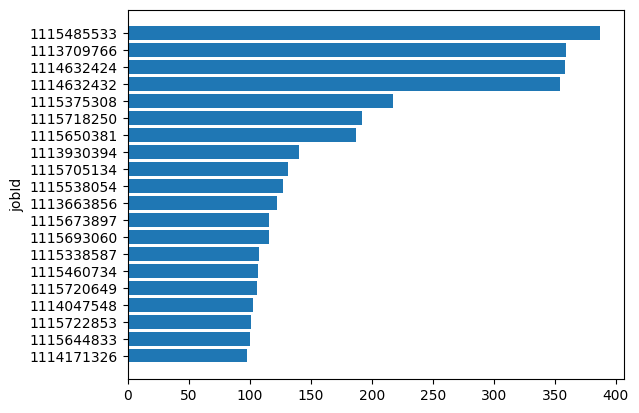

Practicante De Recursos Humanos                    962
Ejecutivo Comercial                                444
Analista Funcional                                 374
Gestor De Servicios De Ti                          359
Asistente De Recursos Humanos                      354
Jefe De Proyecto - Analytics & Ai                  294
Asistente Social                                   288
Practicante De Infrastructure & Cloud              279
Programador .Net                                   275
Analista Programador                               255
Asistente De Pmo                                   243
Community Manger                                   187
Desarrollador .Net                                 181
Analista De Calidad                                177
Ejecutivo(A) Comercial Ti                          160
Jefe De Proyectos - Analytics & Ai                 152
Lider Tecnico                                      148
Jefe De Proyecto Para El Area De Analytics & Ai    140
Cloud Spec

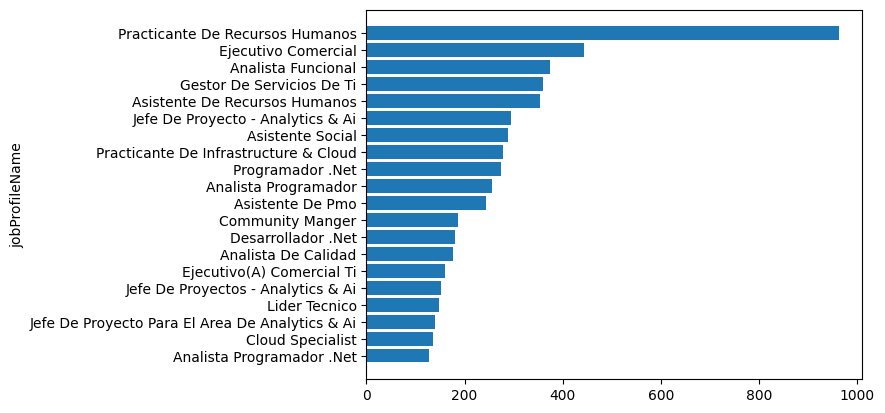

Peru                    9980
Venezuela                145
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Republica Dominicana       2
Chile                      2
Bolivia                    1
Francia                    1
Costa Rica                 1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateResidenceCountry, dtype: int64


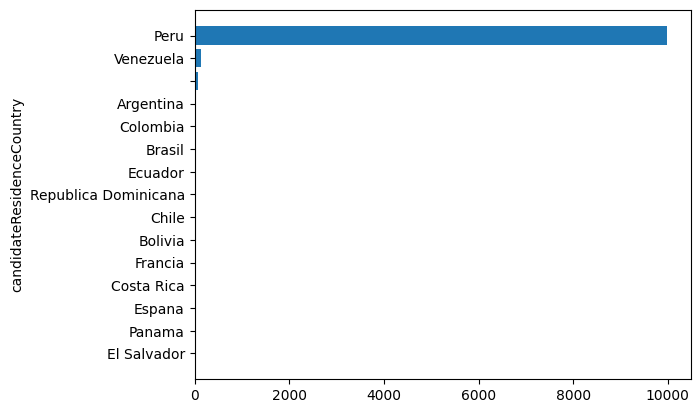

Soltero/A          7832
Casado/A           1487
                    623
Divorciado/A        126
Pareja De Hecho     108
Union Libre          46
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


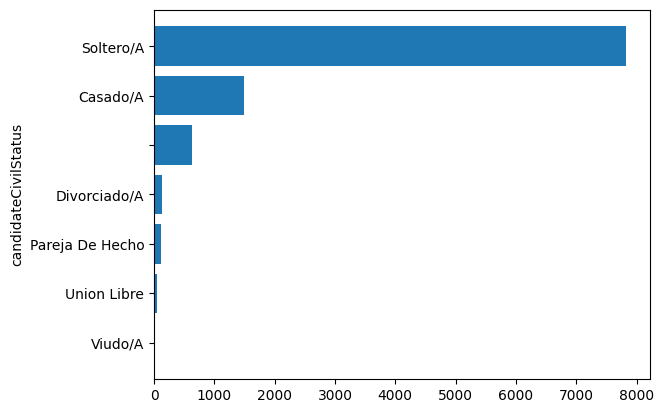

            268
43319681     78
43462768     35
41002160     27
43015660     26
18229064     23
45732690     21
10315458     18
45419217     17
42030318     15
12345678     15
40613584     14
46596341     14
44174897     14
47088768     13
44178991     13
07968889     13
70008340     13
45941486     12
46688979     12
Name: candidateDocumentNumber, dtype: int64


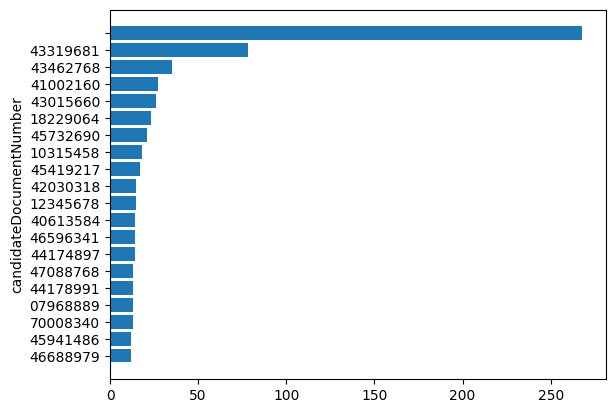

              231
1985-07-13     84
1979-09-30     42
1985-04-08     26
1986-01-18     25
1978-01-21     23
1989-02-25     22
1975-05-15     18
1988-11-18     17
1990-09-11     17
1990-12-15     17
1987-04-13     16
1980-07-24     15
1982-10-16     15
1990-02-24     14
1968-10-29     13
1988-08-17     13
1987-01-01     13
1980-05-03     12
1980-11-05     12
Name: candidateBirthDate, dtype: int64


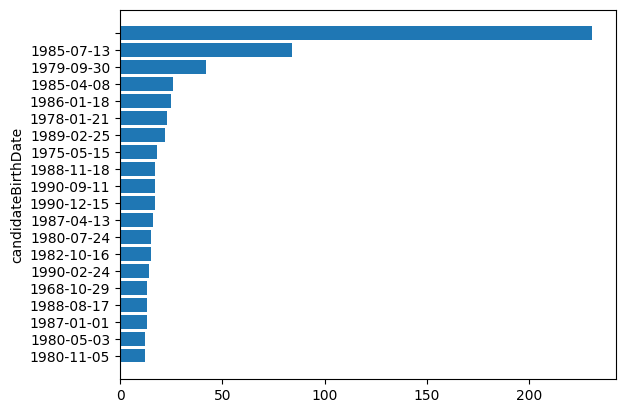

Peru                    9980
Venezuela                145
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Republica Dominicana       2
Chile                      2
Bolivia                    1
Francia                    1
Costa Rica                 1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateBirthCountry, dtype: int64


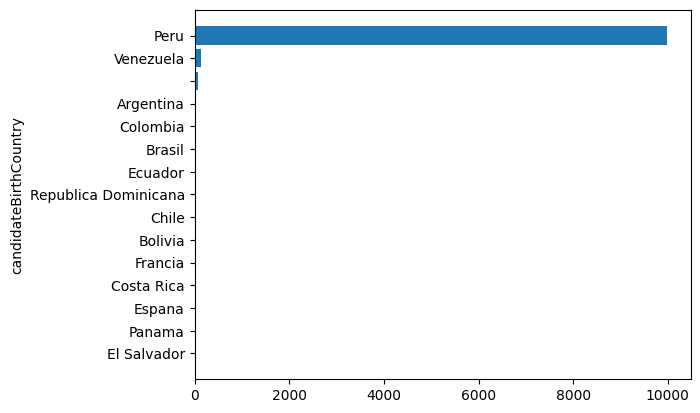

                                                                                        666
Lima, Lima, Lima, Peru                                                                   78
Neruda, Lima, Lima, Peru                                                                 46
., Lima, Lima, Peru                                                                      32
Jr Ica 950, Lima, Lima, Peru                                                             26
Calle Valladolid # 128 Urbanizacion Mayorazgo - Ate, Ate, Lima, Peru                     25
Santa Anita , Lima, Lima, Peru                                                           24
Calle 13 De Abril 910, Arequipa, Arequipa, Peru                                          21
Calera De La Merced 248, Surquillo, Lima, Peru                                           20
-, Lima, Lima, Peru                                                                      17
Begonias, Carabayllo, Lima, Peru                                                

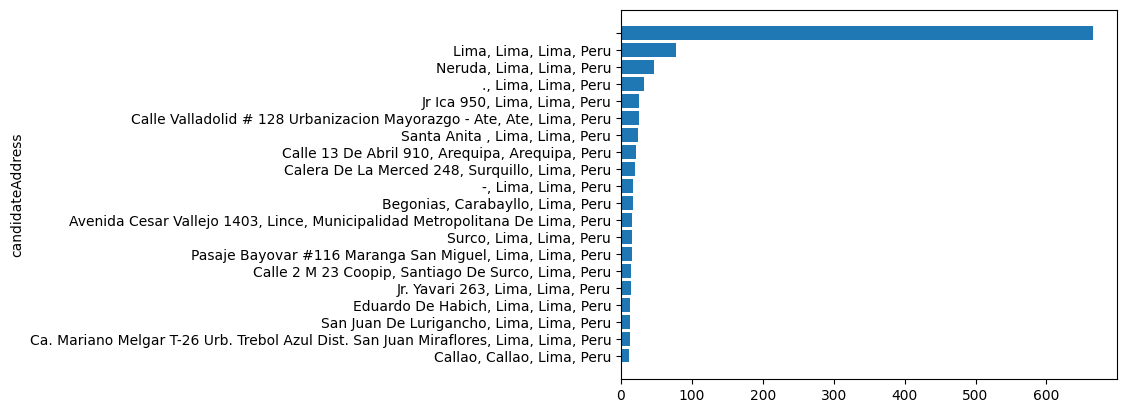

                 4937
51                690
+                 137
01                 78
511                63
51 910984054       45
51 931810142       24
+51                17
511 5748571        14
51 995384149       13
01 2580077         12
511 4342693        11
5775611 01         11
01 0               11
01 4643843          9
51 5611445          9
051 7473619         9
51 993596249        9
01 3997952          9
1                   8
Name: candidateHomeNumber, dtype: int64


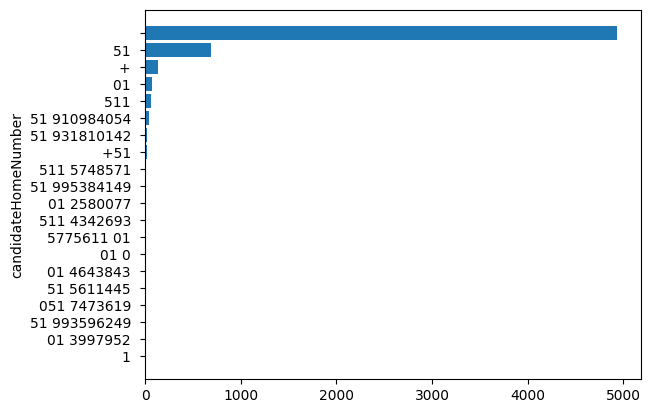

                       79
51 910984054           45
511 949346218          27
51 931810142           24
054 973583947          21
+51 950001939          20
51 994637675           18
51 997671135           15
51 949346218           15
511 992028085          14
51 940442936           14
0511 933480280         14
01 959053787           13
51 995384149           13
511 946059246          13
51 991064075           12
951901566              11
511 958960663          11
51-1 997671135         10
932458838 932458838    10
Name: candidateCellphoneNumber, dtype: int64


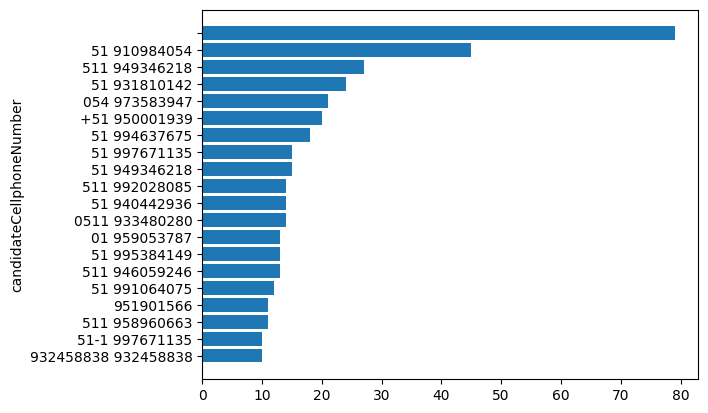

Jurqui29@Outlook.Com            78
Hcortez2011@Gmail.Com           42
Amirandac36@Gmail.Com           35
Villamoralesjulia@Gmail.Com     26
Gastoni21@Hotmail.Com           23
Alevca@Hotmail.Com              21
Paco150575@Hotmail.Com          18
Asistemas200920341@Gmail.Com    17
Ricardo_I14@Hotmail.Com         17
Eduardopassano82@Hotmail.Com    15
Renato.Mzc1990@Gmail.Com        14
John.Panana@Gmail.Com           14
Leono13@Live.Com                14
Willy.Olortegui@Gmail.Com       13
Rosa.Huirset@Gmail.Com          13
Guillermoherenciav@Gmail.Com    13
Nirvana_566@Hotmail.Com         12
Pjrcb@Yahoo.Es                  12
Alez1512@Hotmail.Com            12
Randy.Silva@Gmail.Com           11
Name: candidateEmail, dtype: int64


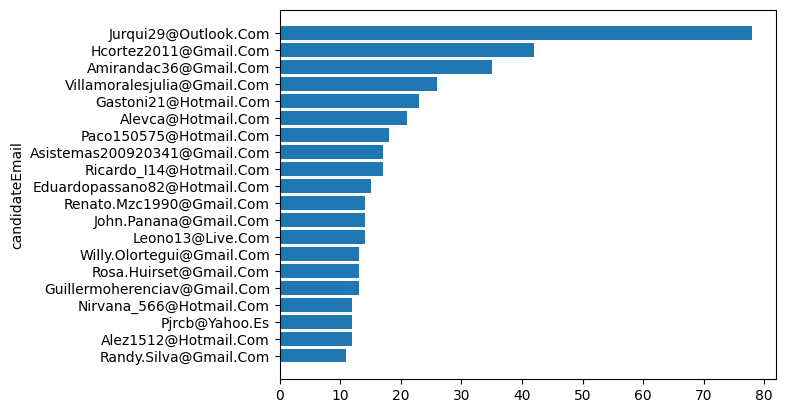

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1285
Me Desempeno En El Area D

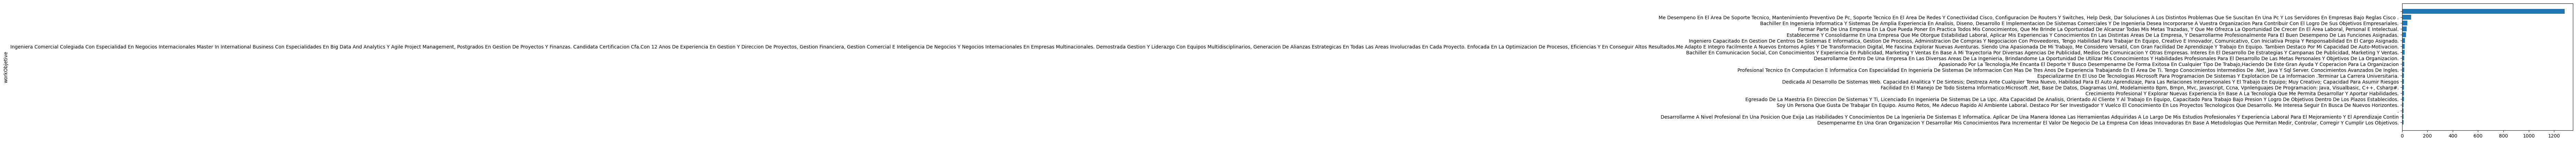

5000    617
2500    617
2000    588
3500    562
3000    549
4000    532
1500    472
6000    438
0       424
4500    405
1200    362
1800    354
5500    302
1025    298
7000    283
1000    282
6500    281
930     227
8000    202
1       201
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


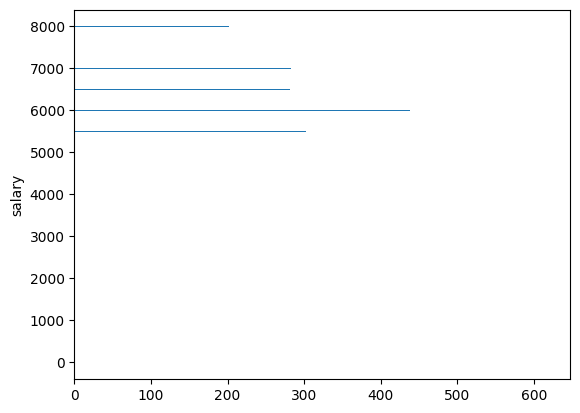

0      595
61     160
92     153
153    152
122    146
365    136
184    102
212     91
31      88
214     83
91      81
181     81
151     80
334     80
273     74
183     69
59      64
275     64
366     63
182     58
Name: lastWorkDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


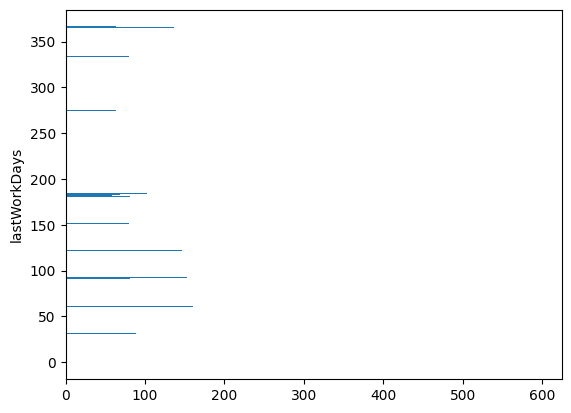

                                            562
Canvia                                      133
Freelance (Clientes)                         78
Global Hitss                                 69
Everis                                       59
Independiente                                56
Mdp Consulting                               52
Indra                                        49
Banco De Credito Del Peru                    38
Tata Consultancy Services                    38
Everis Peru Sac                              33
Pontificia Universidad Catolica Del Peru     26
Panacea Consultores S.A.                     26
Tgestiona                                    25
Experis                                      25
Everis Peru                                  24
Onpe                                         24
Interbank                                    22
Freelance                                    22
Mdp                                          22
Name: lastWorkCompany, dtype: int64


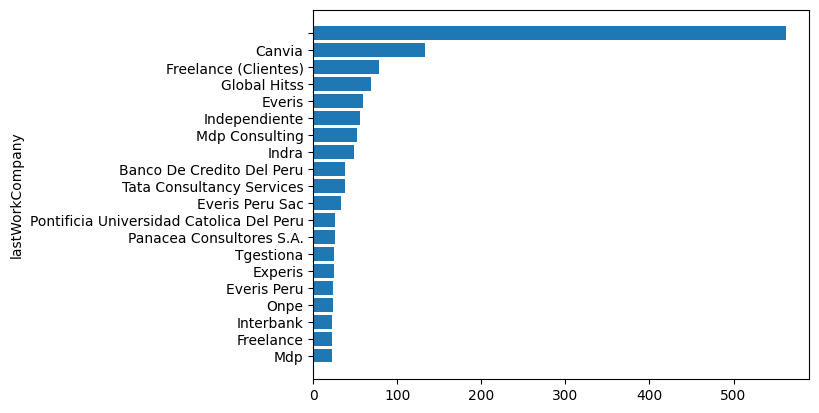

Peru              9488
                   562
Estados Unidos      31
Venezuela           25
Espana              23
Colombia            17
Brasil              16
Chile               12
Argentina            7
Ecuador              7
Mexico               4
Albania              3
Reino Unido          3
Costa Rica           3
Finlandia            2
Australia            2
Francia              2
Italia               2
Paises Bajos         2
Panama               2
Name: lastWorkCountry, dtype: int64


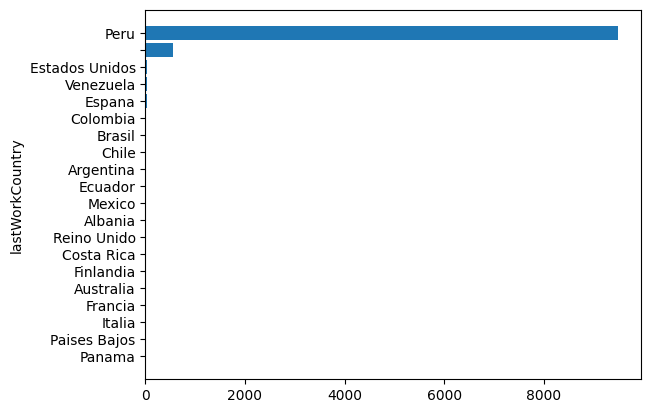

Tecnologia / Sistemas            1047
Tecnologias De La Informacion    1027
Programacion                      590
Liderazgo De Proyecto             587
                                  562
Comercial                         553
Sistemas                          489
Recursos Humanos                  438
Ventas                            267
Administracion                    258
Analisis De Datos                 237
Analisis Funcional                221
Infraestructura                   216
Soporte Tecnico                   202
Atencion Al Cliente               164
Seguridad Informatica             156
Otras Ingenierias                 151
Desarrollo De Negocios            132
Testing / Qa / Qc                 128
Telecomunicaciones                119
Name: lastWorkArea, dtype: int64


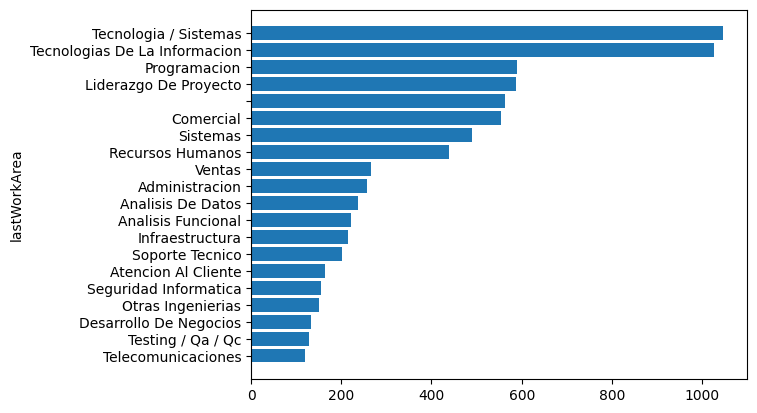

                                                562
Analista Programador                            399
Analista De Sistemas                            192
Analista Funcional                              122
Jefe De Proyectos                                83
Trabajadora Social                               82
Supervisor De Infraestructura De Redes Cisco     78
Asistente Administrativo                         69
Project Manager                                  55
Asesor Comercial                                 54
Practicante                                      51
Analista                                         50
Ejecutivo Comercial                              50
Asistente De Recursos Humanos                    49
Analista De Sistemas Senior                      47
Jefe De Sistemas                                 39
Programador                                      39
Key Account Manager                              39
Lider Tecnico                                    36
Soporte Tecn

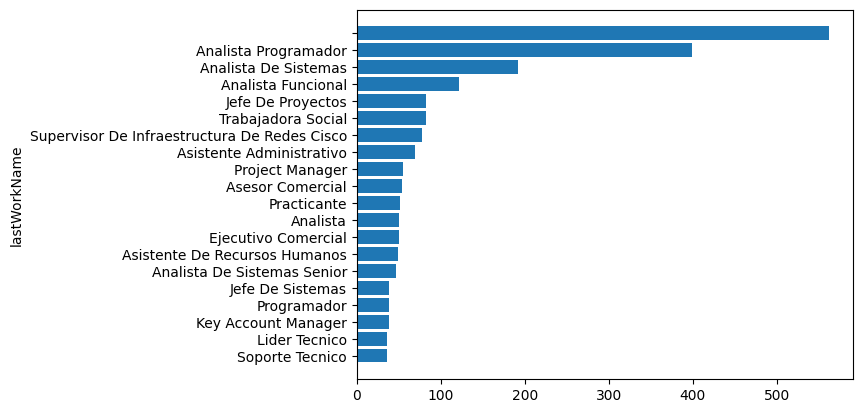

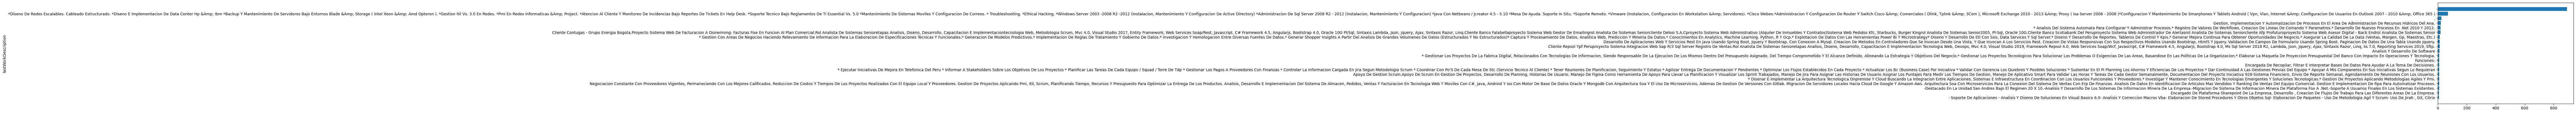

0     1162
4      736
5      698
8      678
7      665
6      654
2      651
1      643
3      619
9      537
10     505
11     426
12     310
13     308
15     258
14     249
16     179
17     128
20     111
19     110
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


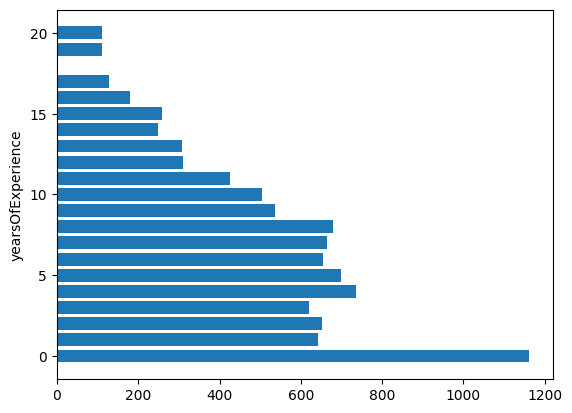

5     1300
4     1184
6     1059
3     1021
7      935
2      740
8      735
1      663
0      562
9      530
10     407
11     274
12     238
13     152
14     119
15      91
17      60
16      45
19      37
18      30
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


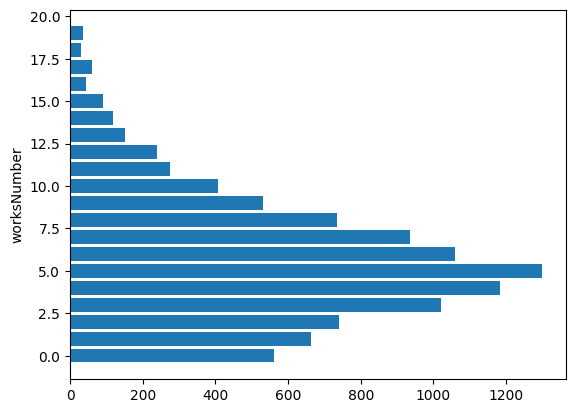

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


0       694
31      311
61      234
30      205
1736    198
92      155
1705    141
122     140
1948    128
153     122
2101    102
1795     99
91       87
1826     80
183      66
1157     63
1218     61
1675     60
123      59
1096     59
Name: lastEducationDays, dtype: int64


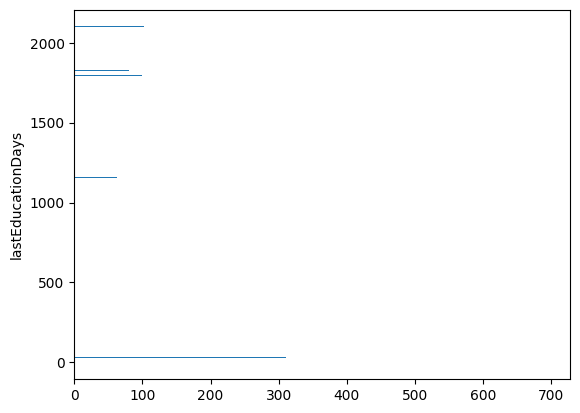

Universidad Peruana De Ciencias Aplicadas    569
Universidad Tecnologica Del Peru             348
Pontificia Universidad Catolica Del Peru     330
Universidad Nacional Mayor De San Marcos     301
Upc                                          295
Universidad Privada Del Norte                293
Universidad Esan                             236
Universidad De Lima                          221
Universidad Cesar Vallejo                    221
Cibertec                                     216
Instituto Cibertec                           202
Universidad Nacional De Ingenieria           198
Universidad De San Martin De Porres          191
                                             183
Universidad Ricardo Palma                    180
Universidad Nacional Federico Villarreal     180
Universidad Inca Garcilaso De La Vega        169
Isil                                         168
Utp                                          159
Universidad San Ignacio De Loyola            137
Name: lastEducationC

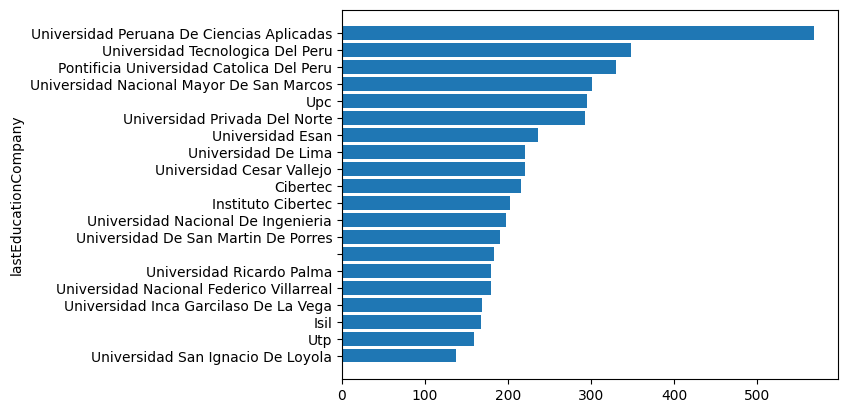

Peru              9488
Espana             197
Venezuela          162
                   123
Estados Unidos      78
Mexico              34
Argentina           20
Colombia            19
Brasil              19
Chile               18
Costa Rica          14
Canada               8
Australia            6
Ecuador              6
Bolivia              6
Francia              5
India                3
Reino Unido          3
Alemania             3
Internacional        2
Name: lastEducationCountry, dtype: int64


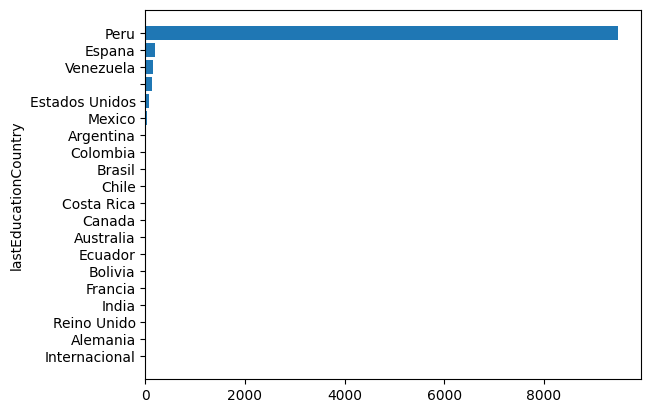

Ing. En Sistemas                  2308
Tecnologias De La Informacion     1237
Adm. De Empresas                  1134
Ing. Informatica                   616
Ing. Industrial                    489
Computacion / Informatica          478
Marketing / Comercializacion       367
Recursos Humanos / Relac. Ind.     354
Psicologia                         347
Otra                               341
                                   204
Ing. - Otros                       191
Trabajo Social                     143
Analisis De Sistemas               138
Ing. Telecomunicaciones            130
Programacion                       122
Telecomunicaciones                 118
Procesos / Calidad Total           104
Finanzas                            95
Bachiller                           91
Name: lastEducationArea, dtype: int64


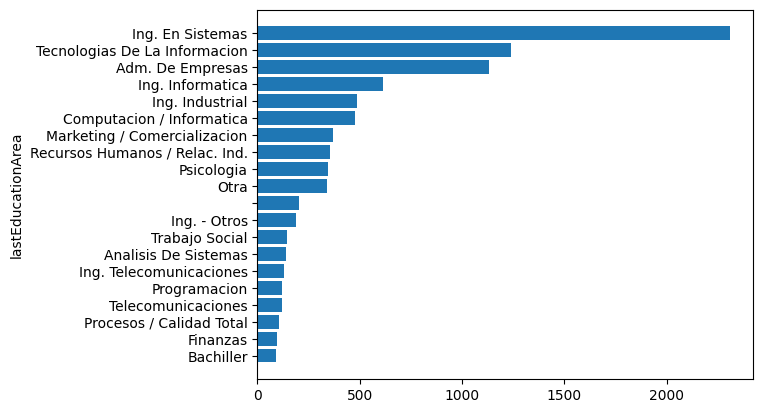

Ingenieria De Sistemas                       782
Ingenieria Industrial                        269
Psicologia                                   251
Administracion De Empresas                   195
Ingeniero De Sistemas                        182
Computacion E Informatica                    172
Ingenieria De Sistemas E Informatica         151
                                             126
Administracion                               126
Bachiller En Ingenieria De Sistemas           90
Trabajo Social                                68
Mba                                           62
Ingenieria De Redes Y Comunicaciones          61
Ingenieria Informatica                        61
Ingles                                        58
Ingenieria De Software                        55
Administracion Y Negocios Internacionales     54
Marketing                                     52
Ingenieria De Computacion Y Sistemas          49
Ingenieria De Sistemas De Informacion         49
Name: lastEducationN

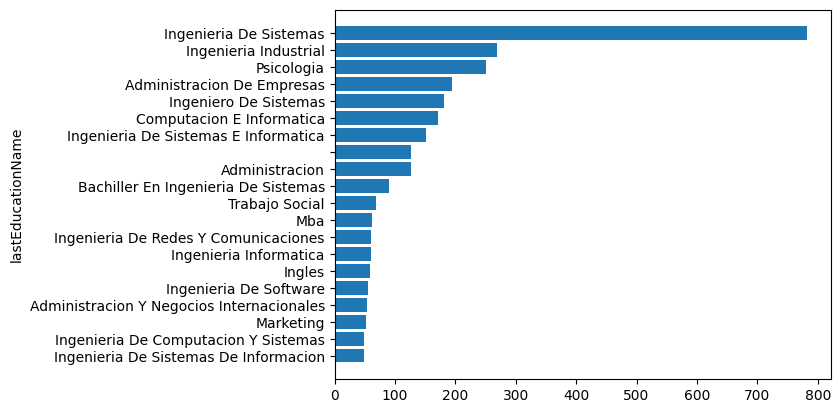

Graduado      6607
En Curso      3326
Abandonado     168
               124
Name: lastEducationStatus, dtype: int64


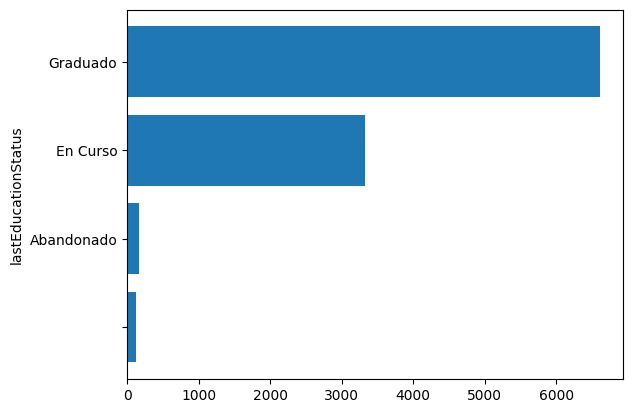

Universitario        5016
Otro                 2274
Posgrado             1176
Terciario/Tecnico    1010
Master                602
                      123
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


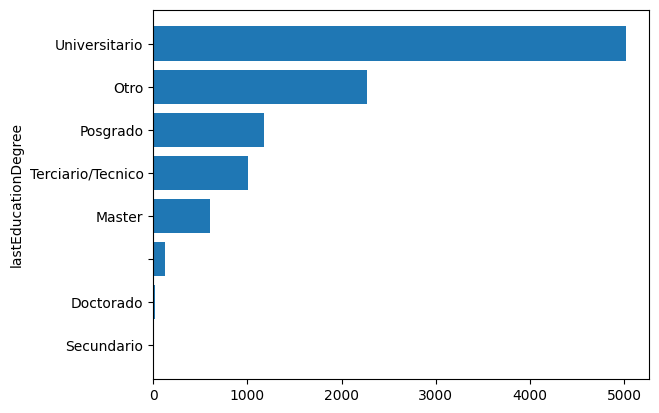

5     1671
6     1352
4     1342
7     1165
8      881
3      680
9      594
10     474
11     339
2      297
12     255
0      203
13     188
14     127
15     114
1       94
16      83
18      60
19      53
20      49
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


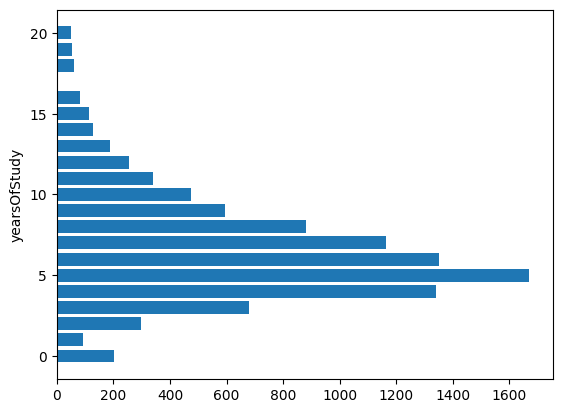

1     3820
2     2349
3     1166
4      711
5      471
6      427
7      283
8      191
9      142
0      123
11     117
10      90
12      69
14      53
13      44
16      25
15      22
20      19
18      18
17      17
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


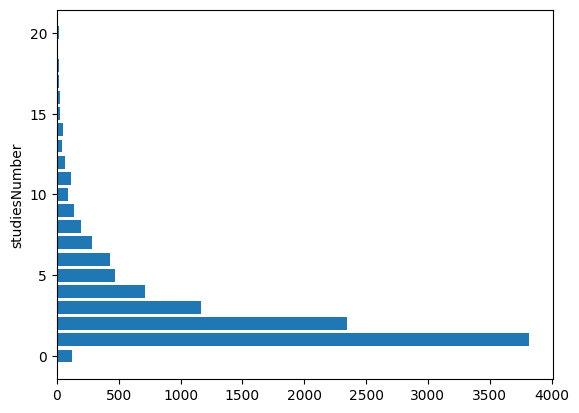

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


0     1220
1     1122
3      863
2      808
4      685
5      586
6      526
7      486
9      448
8      420
11     341
10     336
12     258
13     240
16     231
14     184
15     160
17     126
18     119
21      92
Name: technicalSkills, dtype: int64


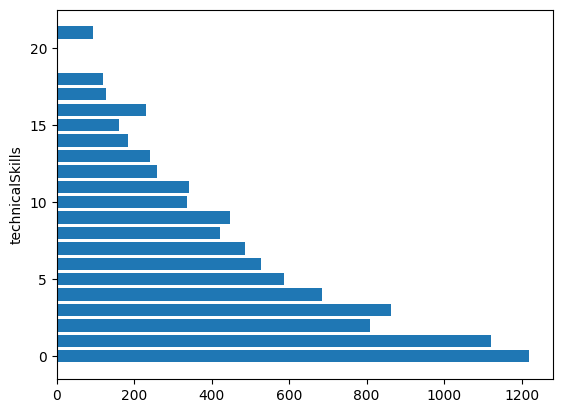

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


1    7122
2    1973
0     772
3     302
4      55
5       1
Name: languages, dtype: int64


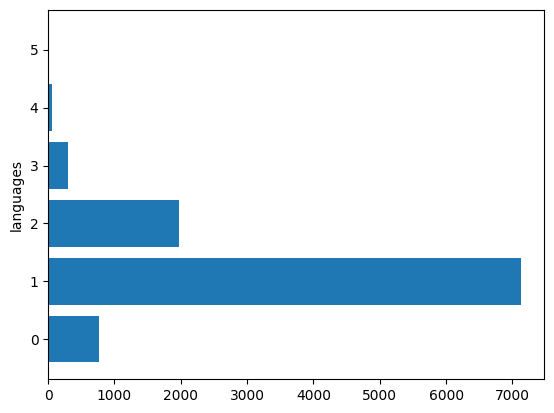

0     2372
1     1752
2     1171
3      835
4      743
5      635
6      494
7      430
8      342
9      274
10     215
11     174
12     139
13     115
14      89
15      69
17      50
16      49
20      36
19      32
Name: otherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_29260\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


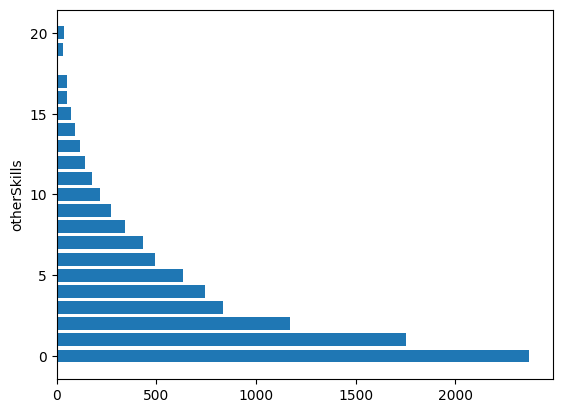

Fin: 2023-05-21 03:49:37.712788
Tiempo: 0:02:06.058651


In [72]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Uniendo la data principal (bumeran + linkedin (ya no))
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()